In [1088]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [1089]:
options = {
    "working electrode": "positive",
}

model = pybamm.lithium_ion.BasicDFNHalfCell(options=options)

## utility functions / submodels

In [1090]:
T = pybamm.Parameter("Temperature [K]")
R = pybamm.Parameter("Molar gas constant [J.mol-1.K-1]")
F = pybamm.Parameter("Faraday constant [C.mol-1]")


def cation_transference_number(c_e, t):
    return 0.0107907 + 1.48837e-3 * c_e


def open_circuit_potential(c_s_p):
    return 2.7 + (R * T / F) * (-0.000558 * c_s_p + 8.10)


def volume_change_coeff(c_e):
    return 1


def current_function(t):
    return 2.5

## select and update parameters

In [1091]:
# default parameters
chemistry = pybamm.parameter_sets.Chen2020
param = pybamm.ParameterValues(chemistry=chemistry)

param.update(
    {
        "Electrode cross-sectional area [m2]": 1,
        "Faraday constant [C.mol-1]": 96485,
        "Lithium counter electrode exchange-current density [A.m-2]": 12.6,
        "Lithium counter electrode conductivity [S.m-1]": 1.0776e7,
        "Lithium counter electrode thickness [m]": 50e-6,
        "Maximum concentration in the solid [mol.m-3]": 29000,
        "Maximum working particle surface concentration": 3920,
        "Molar gas constant [J.mol-1.K-1]": 8.314,
        "Positive electrode active material volume fraction": 0.65,
        "Positive electrode OCP [V]": open_circuit_potential,
        'Positive electrode thickness [m]': 100e-06,
        "Positive particle radius [m]": 1e-6,
        "Separator porosity": 0.05,
        "Separator thickness [m]": 50e-6,
        "Temperature [K]": 373.15,
    },
    check_already_exists=False,
)

param["Initial concentration in negative electrode [mol.m-3]"] = 1000
param["Current function [A]"] = current_function

In [1092]:
# add lithium counter electrode parameter values
# param.update(
#     {
#         "1 + dlnf/dlnc": 1,
#         "Cation transference number": cation_transference_number,
#         "Current function [A]": current_function,
#         "Diffusion coefficient [m2.s-1]": 5e-13,
#         "EC diffusivity [m2.s-1]": 5e-13,
#         "Discharge capacity [A.h]": 50,
#         "Electrode cross-sectional area [m2]": 1,
#         "Electrolyte conductivity [S.m-1]": 1e4,
#         "Faraday constant [C.mol-1]": 96485,
#         "Initial concentration in negative electrode [mol.m-3]": 1000,
#         "Initial concentration in electrolyte [mol.m-3]": 1000,
#         "Initial temperature [K]": 373.15,
#         "Lithium counter electrode exchange-current density [A.m-2]": 12.6,
#         "Lithium counter electrode conductivity [S.m-1]": 1.0776e7,
#         "Lithium counter electrode thickness [m]": 50e-6,
#         "Lower voltage cut-off [V]": 1.7,
#         "Maximum concentration in the solid [mol.m-3]": 29000,
#         "Maximum working particle surface concentration": 3920,
#         "Molar gas constant [J.mol-1.K-1]": 8.314,
#         "Positive electrode active material volume fraction": 0.65,
#         "Positive electrode porosity": 0.05,
#         "Positive electrode conductivity [S.m-1]": 5e-2,
#         "Positive electrode diffusivity [m2.s-1]": 7.5e-12,
#         "Positive electrode OCP [V]": open_cell_potential,
#         'Positive electrode thickness [m]': 100e-06,
#         "Positive particle radius [m]": 10e-6,
#         "Separator porosity": 0.05,
#         "Separator thickness [m]": 50e-6,
#         "Temperature [K]": 373.15,
#     },
#     check_already_exists=False,
# )

## geometry of the cell

In [1093]:
# set geometry
geometry = model.default_geometry

In [1094]:
param.process_geometry(geometry)

## mesh for discretization

In [1095]:
# set mesh
var_pts = model.default_var_pts
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

In [1096]:
param.process_model(model)
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model);

## solution

In [1097]:
solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)

In [1098]:
t_eval = np.linspace(0, 900, 30)
solution = solver.solve(model, t_eval)

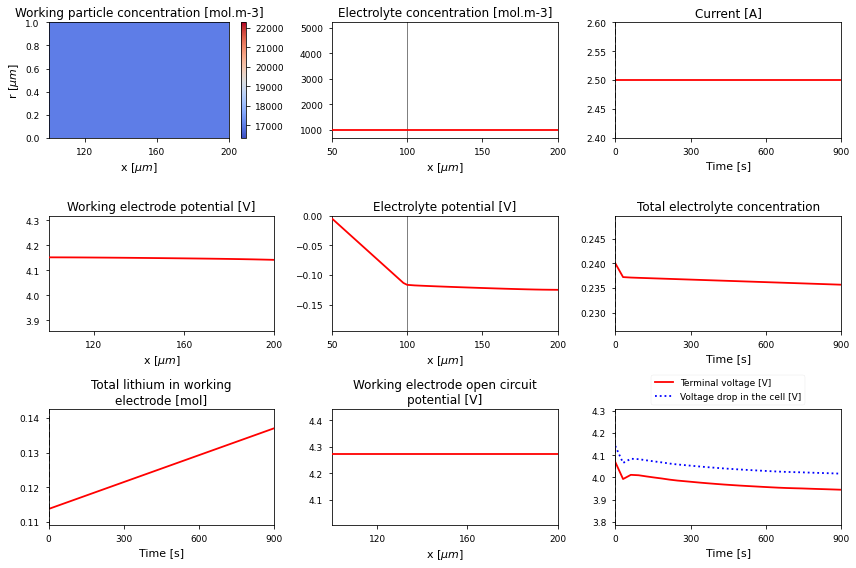

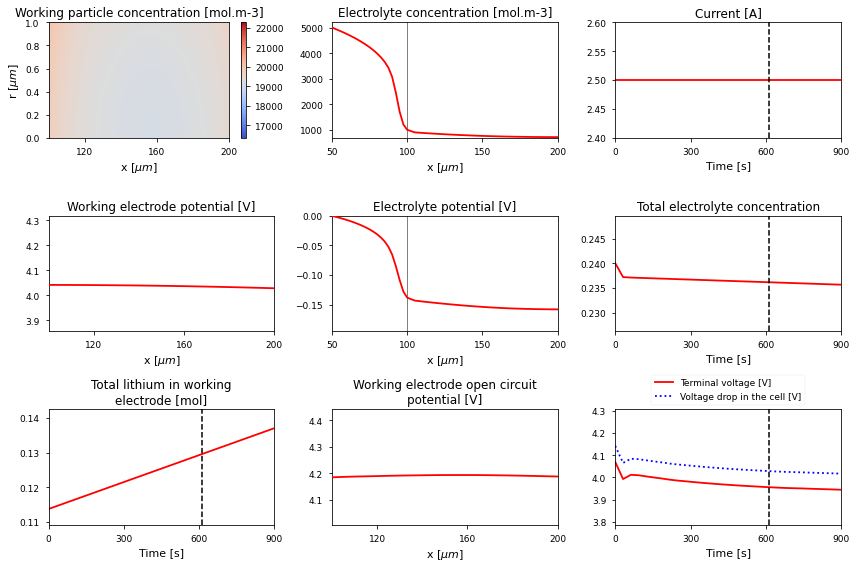

In [1099]:
# plot
plot = pybamm.QuickPlot(
    solution,
    [
        "Working particle concentration [mol.m-3]",
        "Electrolyte concentration [mol.m-3]",
        "Current [A]",
        "Working electrode potential [V]",
        "Electrolyte potential [V]",
        "Total electrolyte concentration",
        "Total lithium in working electrode [mol]",
        "Working electrode open circuit potential [V]",
        ["Terminal voltage [V]", "Voltage drop in the cell [V]"],
    ],
    time_unit="seconds",
    spatial_unit="um",
)
plot.dynamic_plot()

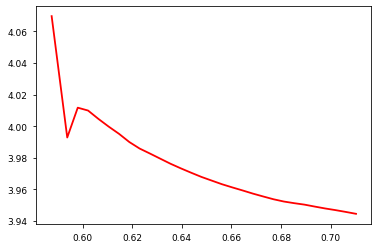

In [1100]:
plt.plot(solution["X-averaged working particle surface concentration [mol.m-3]"].data / 29000,
        solution["Terminal voltage [V]"].data
        )

In [1101]:
solution["X-averaged working particle surface concentration [mol.m-3]"].data

array([17038.        , 17220.41602617, 17343.34238503, 17464.05787463,
       17584.57352564, 17705.06905728, 17825.56197253, 17946.054608  ,
       18066.54716234, 18187.03969033, 18307.53220912, 18428.02472693,
       18548.51724445, 18669.00976188, 18789.50227928, 18909.99479667,
       19030.48731407, 19150.97983146, 19271.47234885, 19391.96486625,
       19512.45738364, 19632.94990103, 19753.44241842, 19873.93493582,
       19994.42745321, 20114.9199706 , 20235.41248799, 20355.90500539,
       20476.39752278, 20596.89004017])